<a href="https://colab.research.google.com/github/pietrodantuono/api-24sea-get-data-example/blob/main/API_24SEA_data_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
%config InteractiveShell.ast_node_interactivity = 'all'
%config Completer.use_jedi = False

# 24SEA API

  **10-minute metric signals** that are collected by the 24SEA SHM system. The 10-minute metric signals (from now on addressed as metrics) are the cleaned and aggregated data calculated on a 10-minute basis. The metrics are calculated from the high-frequency raw data collected by the 24SEA SHM system. 24SEA does not provide direct access to the raw data as it needs to be processed and aggregated to be useful.

*We chose 10 minutes as the aggregation period because it has become an industry standard for SHM systems, since it is a good balance between the need for high temporal resolution and the need for a manageable amount of data.*

Users can verify which metrics they can access by inspecting their Datasignals App UI at https://api.24sea.eu/datasignals.

API documentation at https://api.24sea.eu/redoc/v1#section/Introduction.


In [2]:
from IPython.display import HTML, display

html_code = """
<div id="container">
  <h2 id="text-before">24SEA API documentation homepage</h2>
  <iframe id="iframe1"
    src="https://api.24sea.eu/redoc/v1"></iframe>
  <h2 id="text-between">api-24sea Python (helper) package</h2>
  <iframe id="iframe2"
    src="https://api24seapydocs.z6.web.core.windows.net"></iframe>
</div>

<script>
  // Get the Barlow font
  @import url('https://fonts.googleapis.com/css2?family=Barlow:ital,wght@0,100;0,200;0,300;0,400;0,500;0,600;0,700;0,800;0,900;1,100;1,200;1,300;1,400;1,500;1,600;1,700;1,800;1,900&display=swap');
  // Get the container, iframes, and text element
  const container = document.getElementById('container');
  const iframe1 = document.getElementById('iframe1');
  const iframe2 = document.getElementById('iframe2');
  const textBefore = document.getElementById('text-before');
  const textBetween = document.getElementById('text-between');

  // Create a new iframe
  const mergedIframe = document.createElement('iframe');
  mergedIframe.width = '100%';
  mergedIframe.height = '1500px'; // Adjust height as needed

  // Create a document for the new iframe
  const mergedDoc = mergedIframe.contentDocument || mergedIframe.contentWindow.document;

  // Copy contents of iframe1, text, and iframe2 to the new iframe
  mergedDoc.body.innerHTML = textBefore.outerHTML + iframe1.outerHTML + textBetween.outerHTML + iframe2.outerHTML;

  // Replace the container with the merged iframe
  container.innerHTML = '';
  container.appendChild(mergedIframe);
</script>
<style>
  h2 {
    color: #4b5e84 !important;
    font-family: Barlow, sans-serif !important;
    font-weight: 500 !important;
  }
  iframe {
    border-radius: 6px;
    border-color: #4b5e84;
    border-width: 2px;
    border-style: solid;
    width: 900px;
    height: 500px;
  }
  #text-before, #text-between {
    color: #4b5e84;
    font-family: Barlow, sans-serif;
    font-weight: 400;
  }
</style>
"""

display(HTML(html_code))

In [3]:
%%capture
! pip install pandas api-24sea python-dotenv matplotlib;

In [21]:
# **Package Imports**
# - From the Python Standard Library
import logging
import os
import sys

# - From third party libraries
from google.colab import userdata
import matplotlib.pyplot as plt
import pandas as pd

# - Local imports
from api_24sea.version import __version__
import api_24sea


In [5]:
# Some plot settings
plt.rcParams['figure.figsize'] = (15/2.514/0.7, 5/2.514/0.7)
plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.size"] = 10.5
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.color'] = "#DDDDDD"
plt.rcParams['grid.linestyle'] = "-"
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['lines.markersize'] = 3
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = True


In [6]:
# **Package Versions**
pad_len = 20
print(f"\033[1;32m{'‣ Working folder:'.ljust(pad_len)} \033[35m{os.getcwd()}")
print(f"\033[1;32m{'‣ Python Version:'.ljust(pad_len)} \033[35m{sys.version}")
print(f"\033[1;32m{'‣ Pandas Version:'.ljust(pad_len)} \033[35m{pd.__version__}")
print(f"\033[1;32m{'‣ API-24SEA Version:'.ljust(pad_len)} \033[35m{__version__}")
# **Notebook Configuration**
logging.basicConfig(level=logging.INFO)

‣ Working folder:    /content
‣ Python Version:    3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
‣ Pandas Version:    2.2.2
‣ API-24SEA Version: 0.9.3


## Setting up the authentication credentials

The API requires *basic-auth*, meaning that credentials, namely `(username, password)`, must be provided to get data.

In a generic Jupyter Notebook, credentials could be for example stored in a file called `.env` in the same path as the notebook, containing the following information:

```shell
API_USERNAME=your_username
API_PASSWORD=your_password
```

The variables could then be loaded as follows:

```python
_ = dotenv.load_dotenv(".env")
if _:
    print("\033[32mEnvironment Variables Loaded Successfully\033[0m\n")
    username = os.getenv("API_USERNAME")
    password = os.getenv("API_PASSWORD")
    print(f"\033[1mAPI_USERNAME: \033[35m{username}\033[0m")
    print(f"\033[1mAPI_PASSWORD: \033[35m{password}\033[0;31m (do not show this one in a production setup!)\033[0;31m")
else:
    raise Exception("\033[1;31mEnvironment Variables Not Loaded. Please check the .env file.\033[0m")
```
For the sake of this Colab Notebook instead, we will exploit Colab Secrets to load the variables using `google.colab.userdata.get`.


In [23]:
# **Load Environment Variables from secrets **
username = userdata.get("API_USERNAME")
password = userdata.get("API_PASSWORD")

print(f"\033[1mAPI_USERNAME: \033[35m{username}\033[0m")
print(f"\033[1mAPI_PASSWORD: \033[35m{password}\033[0;31m (do not show this one in a production setup!)\033[0;31m")


API_USERNAME: Sample.User
API_PASSWORD: CheckOutSomeData! (do not show this one in a production setup!)


## Initializing an empty dataframe

Initializing an empty dataframe is necessary to use the API, as here is where the data will be stored.


In [8]:
# **DataFrame initialization**
# The empty DataFrame is created beforehand because it needs to authenticate
# with the API to fetch the data.
df = pd.DataFrame()

## Authenticating with the API

The authentication step allows the user to access the API and check the available metrics.



In [9]:
# **Authentication**
df.datasignals.authenticate(username, password)

In [10]:
# **Metrics Overview**
# The metrics overview is a summary of the metrics available in the API.
df.datasignals._DataSignals__api.metrics_overview

,CRUD_privileges,data_group,description,end_timestamp,location,metric,print_str,short_hand,site,start_timestamp,statistic,unit_str,site_id,location_id
0,None,acceleration,rms of accelerations measured at WF_A01_NAC_AC...,3000-01-01T00:00:00Z,WFA01,rms_WF_A01_NAC_ACC_FA,NAC ACC FA,NAC_ACC_FA,WindFarm,2000-01-01T00:00:00Z,rms,g,WF,A01
1,None,scada,,3000-01-01T00:00:00Z,WFA01,std_WF_A01_windspeed,Wind speed,windspeed,WindFarm,2000-01-01T00:00:00Z,std,m/s,WF,A01
2,None,acceleration,max of accelerations measured at WF_A01_TW_ACC...,3000-01-01T00:00:00Z,WFA01,max_WF_A01_TW_ACC_LAT100_DEG060_X_nr1,TW ACC LAT100 DEG060 X nr1,TW_ACC_LAT100_DEG060_X_nr1,WindFarm,2000-01-01T00:00:00Z,max,g,WF,A01
3,None,acceleration,std of accelerations measured at WF_A01_NAC_AC...,3000-01-01T00:00:00Z,WFA01,std_WF_A01_NAC_ACC_FA,NAC ACC FA,NAC_ACC_FA,WindFarm,2000-01-01T00:00:00Z,std,g,WF,A01
4,None,fatigue,,3000-01-01T00:00:00Z,WFA01,DEM_WF_A01_TP_SG_LAT010_Mtl,TP SG LAT010 Mtl,TP_SG_LAT010_Mtl,WindFarm,2000-01-01T00:00:00Z,DEM,Nm,WF,A01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,None,load,,3000-01-01T00:00:00Z,WFA02,std_WF_A02_TP_SG_LAT010_Mtn,TP SG LAT010 Mtn,TP_SG_LAT010_Mtn,WindFarm,2000-01-01T00:00:00Z,std,Nm,WF,A02
296,None,acceleration,std of accelerations measured at WF_A02_NAC_ACC_Z,3000-01-01T00:00:00Z,WFA02,std_WF_A02_NAC_ACC_Z,NAC ACC Z,NAC_ACC_Z,WindFarm,2000-01-01T00:00:00Z,std,g,WF,A02
297,None,acceleration,min of accelerations measured at WF_A02_TW_ACC...,3000-01-01T00:00:00Z,WFA02,min_WF_A02_TW_ACC_LAT100_DEG060_X_nr1,TW ACC LAT100 DEG060 X nr1,TW_ACC_LAT100_DEG060_X_nr1,WindFarm,2000-01-01T00:00:00Z,min,g,WF,A02
298,None,acceleration,max of accelerations measured at WF_A02_TW_ACC...,3000-01-01T00:00:00Z,WFA02,max_WF_A02_TW_ACC_LAT100_DEG060_X_nr1,TW ACC LAT100 DEG060 X nr1,TW_ACC_LAT100_DEG060_X_nr1,WindFarm,2000-01-01T00:00:00Z,max,g,WF,A02


## Getting sample data from the API

After loading the environment variables and authenticating with the API, the user can get data from [24SEA API endpoints](https://api.24sea.eu/redoc/v1/).

The data is retrieved and stored in the DataFrame.

When the option as_dict is set to False, the response from each metric is joined on the timestamp which is then set as the index of DataFrame. This option will necessarily drop the location and site columns from the DataFrame, but they can still be retrieved from the metrics names.

The data retrieval is done by specifying the sites or the locations or both, the metrics, and timestamps.

* `sites`: Case insensitive, it can either match site or site_id. It is an optional parameter.
* `locations`: Case insensitive, it can either match location or location_id. It is an optional parameter.
* `metrics`: Case insensitive, it can be a partial match of the metric name
* `(start_timestamp, end_timestamp)`: Timezone-aware [datetime object](https://docs.python.org/3/library/datetime.html), strings in [ISO 8601 format](https://en.wikipedia.org/wiki/ISO_8601), or shorthand strings compatible with the [shorthand_datetime](https://pypi.org/project/shorthand-datetime/) package.


In [11]:
# **Data Retrieval**

sites = ["wf"]
locations = ["a01", "a02"]
metrics = ["mean WinDSpEed", "mean pitch", "mean-Yaw", "mean power", "dem"]

start_timestamp = "2020-03-01T00:00:00Z"
end_timestamp = "2020-06-01T00:00:00Z"

data = df.datasignals.get_data(sites, locations, metrics,
                               start_timestamp, end_timestamp, as_dict=True)


In [12]:
print("\033[34;1mSelected metrics table\033[0m")
df.datasignals.selected_metrics

Selected metrics table


,CRUD_privileges,data_group,description,end_timestamp,location,print_str,short_hand,site,start_timestamp,statistic,unit_str,site_id,location_id
metric,,,,,,,,,,,,,
mean_WF_A01_pitch,None,scada,,3000-01-01T00:00:00Z,WFA01,Pitch,pitch,WindFarm,2000-01-01T00:00:00Z,mean,°,WF,A01
mean_WF_A01_yaw,None,scada,,3000-01-01T00:00:00Z,WFA01,Yaw,yaw,WindFarm,2000-01-01T00:00:00Z,mean,°,WF,A01
mean_WF_A01_windspeed,None,scada,,3000-01-01T00:00:00Z,WFA01,Wind speed,windspeed,WindFarm,2000-01-01T00:00:00Z,mean,m/s,WF,A01
mean_WF_A01_power,None,scada,,3000-01-01T00:00:00Z,WFA01,Power,power,WindFarm,2000-01-01T00:00:00Z,mean,kW,WF,A01
mean_WF_A02_windspeed,None,scada,,3000-01-01T00:00:00Z,WFA02,Wind speed,windspeed,WindFarm,2000-01-01T00:00:00Z,mean,m/s,WF,A02
mean_WF_A02_yaw,None,scada,,3000-01-01T00:00:00Z,WFA02,Yaw,yaw,WindFarm,2000-01-01T00:00:00Z,mean,°,WF,A02
mean_WF_A02_power,None,scada,,3000-01-01T00:00:00Z,WFA02,Power,power,WindFarm,2000-01-01T00:00:00Z,mean,kW,WF,A02
mean_WF_A02_pitch,None,scada,,3000-01-01T00:00:00Z,WFA02,Pitch,pitch,WindFarm,2000-01-01T00:00:00Z,mean,°,WF,A02


In [14]:
# **Data Overview**
print("\033[34;1m\nRetrieved data\033[0m")
data["windfarm"]["WFA01"]


Retrieved data


,site,location,mean_WF_A01_power,mean_WF_A01_yaw,mean_WF_A01_pitch,mean_WF_A01_windspeed
timestamp,,,,,,
2020-03-01 00:00:00+00:00,windfarm,WFA01,-41.469750,154.942861,66.398788,4.756602
2020-03-01 00:10:00+00:00,windfarm,WFA01,-41.730277,154.679861,66.398788,3.286199
2020-03-01 00:20:00+00:00,windfarm,WFA01,-41.638804,118.406361,66.398788,2.772254
2020-03-01 00:30:00+00:00,windfarm,WFA01,-41.464462,124.439561,66.398788,3.068091
2020-03-01 00:40:00+00:00,windfarm,WFA01,-41.569560,132.942861,66.398788,2.258143
...,...,...,...,...,...,...
2020-05-31 23:10:00+00:00,windfarm,WFA01,204.217182,87.034661,45.427588,8.752479
2020-05-31 23:20:00+00:00,windfarm,WFA01,77.331198,87.042861,50.685288,9.028759
2020-05-31 23:30:00+00:00,windfarm,WFA01,230.445580,84.818661,45.030288,8.979204


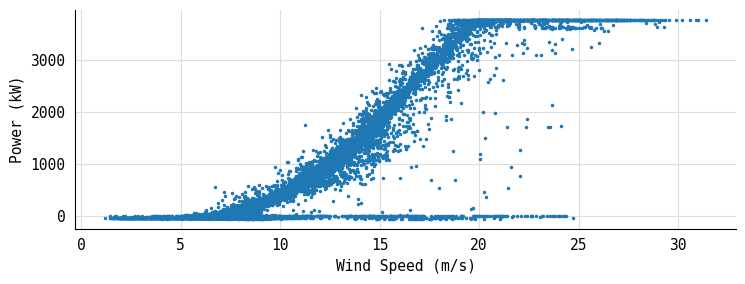

In [19]:
plt.plot(data["windfarm"]["WFA01"]["mean_WF_A01_windspeed"],
         data["windfarm"]["WFA01"]["mean_WF_A01_power"],
         ls="", marker=".")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power (kW)")
plt.show();
